# Isolation Forest 異常偵測教學

Isolation Forest 是一種基於樹模型的異常偵測方法，適合用於高維度資料。

本教學將由淺入深，帶你了解 Isolation Forest 的原理、視覺化範例，並以實際詐欺資料集進行應用與解釋。

**目標：**
- 了解 Isolation Forest 的基本概念
- 以 toy data 視覺化異常偵測流程
- 實際應用於詐欺資料集
- 以 SHAP 解釋模型結果

---

## 1. Isolation Forest 原理簡介

Isolation Forest 透過隨機分割特徵空間，將資料點隔離。
異常點通常較容易被隔離，因此平均隔離路徑較短。

**主要特點：**
- 適合高維度資料
- 不需標記資料
- 計算效率高

Isolation Forest 的流程如下：
1. 隨機選擇特徵與分割值，建立樹結構
2. 計算每個資料點被隔離所需的平均路徑長度
3. 路徑越短，越可能是異常點

---

## 2. 簡單範例：toy data 異常偵測與視覺化

我們先用 2D toy data 來示範 Isolation Forest 如何分辨正常與異常點。

### Load and Visualize Toy Data

We will generate a synthetic dataset with normal points and some anomalies, then visualize it.

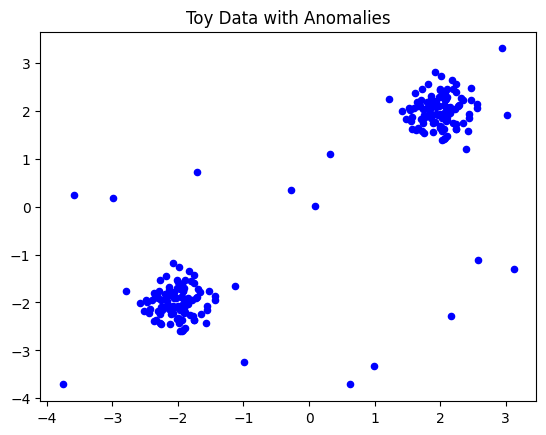

In [7]:
# 產生 toy data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)
# 隨機生成 100 筆 2 維的常態分布資料，乘上 0.3 讓資料分布更集中。
X = 0.3 * rng.randn(100, 2)
# 分別將資料平移到 (2, 2) 和 (-2, -2) 兩個位置，形成兩群正常資料。
X = np.r_[X + 2, X - 2]
# 加入一些異常點
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))
X_full = np.r_[X, X_outliers]

# 視覺化資料
plt.scatter(X_full[:, 0], X_full[:, 1], color='b', s=20)
plt.title("Toy Data with Anomalies")
plt.show()

### Outliner detection with Isolation Forest


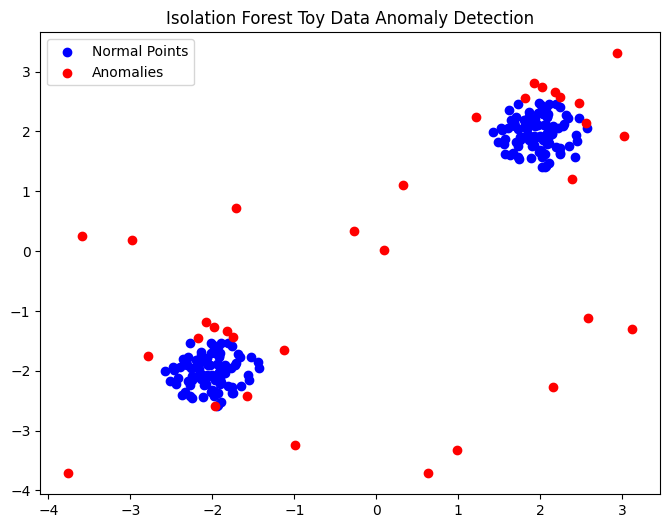

In [10]:
# 建立 Isolation Forest
clf = IsolationForest(contamination=0.15, random_state=42)
clf.fit(X_full)
y_pred = clf.predict(X_full)

# 視覺化結果
plt.figure(figsize=(8, 6))
plt.scatter(X_full[y_pred == 1, 0], X_full[y_pred == 1, 1], c='blue', label='Normal Points')
plt.scatter(X_full[y_pred == -1, 0], X_full[y_pred == -1, 1], c='red', label='Anomalies')
plt.title('Isolation Forest Toy Data Anomaly Detection')
plt.legend()
plt.show()

## 3. 實際應用：詐欺資料集偵測

接下來我們將使用 `InsFraudDataset6.csv` 資料集，利用 Isolation Forest 進行詐欺偵測。

資料集包含多個保險相關特徵，目標是找出潛在異常（詐欺）案件。

In [12]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# 讀取資料集
data = pd.read_csv('text-book/InsFraudDataset6.csv')

# 建立 Isolation Forest 模型
model = IsolationForest(contamination=0.25, random_state=42)
model.fit(data)

# 預測異常分數與標記
anomaly_scores = model.decision_function(data)
predictions = model.predict(data)

# 將結果加入 DataFrame
df = data.copy()
df['Anomaly_Score'] = anomaly_scores
df['Prediction'] = predictions

# 顯示部分結果
df.head(10)

Severity   Age  policy_annual_premium  total_claim_amount  policy_number  \
0         3  22.0                1406.91               71610         521585   
1         1  38.0                1197.22                5070         342868   
2         3  26.0                1413.14               34650         687698   
3         1  35.0                1415.74               63400         227811   
4         3  35.0                1583.91                6500         367455   
5         3  27.0                1351.10               64100         104594   
6         1  54.0                1333.35               78650         413978   
7         3   2.0                1137.03               51590         429027   
8         3  27.0                1442.99               27700         485665   
9         2  14.0                1315.68               42300         636550   

   injury_claim  property_claim  vehicle_claim  Anomaly_Score  Prediction  
0          6510           13020          52080       0.088964           1  
1           780             780           3510       0.026786           1  
2          7700            3850          23100       0.043323           1  
3          6340            6340          50720       0.062456           1  
4          1300             650           4550       0.027444           1  
5          6410            6410          51280       0.065281           1  
6         21450            7150          50050      -0.033005          -1  
7          9380            9380          32830       0.040872           1  
8          2770            2770          22160       0.019831           1  
9          4700            4700          32900       0.060027           1

### 視覺化：異常分數分布

我們可以繪製異常分數的分布，觀察異常點與正常點的差異。

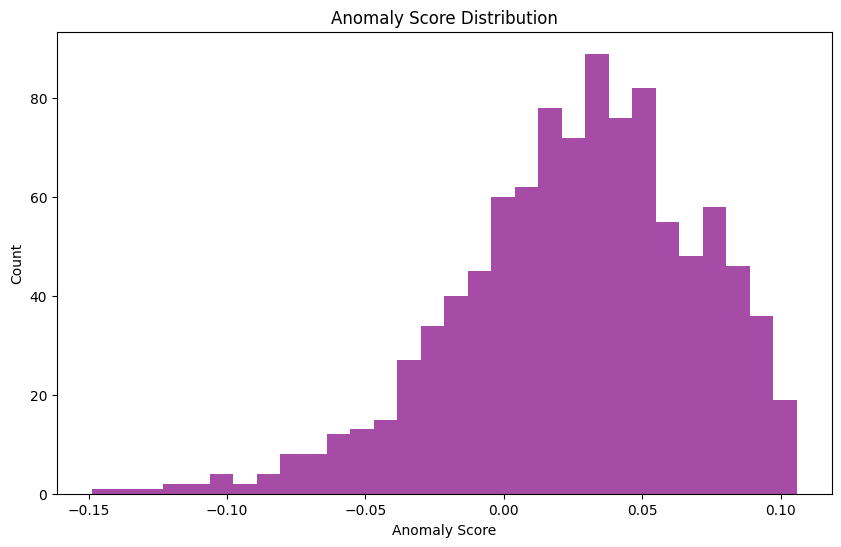

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df['Anomaly_Score'], bins=30, color='purple', alpha=0.7)
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.show()

## 4. SHAP 解釋 Isolation Forest 模型

為了更好地理解模型如何判斷異常，我們可以利用 SHAP 進行解釋。
SHAP 能夠告訴我們哪些特徵對於某筆資料被判定為異常有最大影響。

/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ExactExplainer explainer: 1001it [00:46, 17.81it/s]                                                                                                                                         


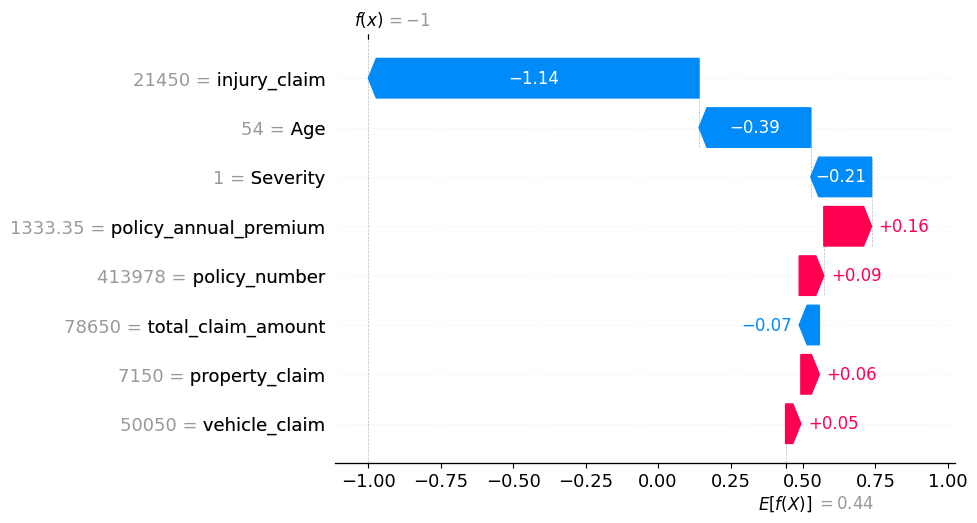

In [16]:
import shap
# 建立 SHAP explainer
explainer = shap.Explainer(model.predict, data)
shap_values = explainer(data)

# 視覺化第一筆異常資料的 SHAP 值
anomaly_idx = df[df['Prediction'] == -1].index[0]
shap.plots.waterfall(shap_values[anomaly_idx])

## 5. 小結與延伸閱讀

Isolation Forest 是一種高效且無監督的異常偵測方法，適合用於高維度資料。

**延伸閱讀：**
- [Isolation Forest 原始論文](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)
- [scikit-learn IsolationForest 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
- [SHAP 官方文件](https://shap.readthedocs.io/en/latest/)

---

你可以嘗試調整 contamination 參數、或用不同資料集進行異常偵測，並用 SHAP 進行模型解釋。